<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Before-you-start" data-toc-modified-id="Before-you-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Before you start</a></span></li><li><span><a href="#Authentication-setup" data-toc-modified-id="Authentication-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Authentication setup</a></span></li><li><span><a href="#Hands-off-workflow" data-toc-modified-id="Hands-off-workflow-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hands-off workflow</a></span></li></ul></div>

# Analysis Ready Data (ARD) workflow for MODIS Aqua L2P SST collection

This notebook demonstrates how to created a gridded "Data Cube", essentialy an ARD, from native Level 2P sea surface temperature (SST) data from the MODIS Aqua (https://doi.org/10.5067/GHMDA-2PJ19) collection or dataset.  It can also be applied to Terra L2P SST and other similar L2 satellite collections.


## Before you start

Before you beginning this tutorial, make sure you have an Earthdata account: [https://urs.earthdata.nasa.gov](https://urs.earthdata.nasa.gov) for the operations envionrment (most common) or [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov) for the UAT environment.

Accounts are free to create and take just a moment to set up.

## Authentication setup

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

*You'll need to authenticate using the netrc method when running from command line with [`papermill`](https://papermill.readthedocs.io/en/latest/). You can log in manually by executing the cell below when running in the notebook client in your browser.*

In [9]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc
import requests
import urllib
import json
import pprint
import time
import os
from os import makedirs, path
from os.path import isdir, basename
from urllib.parse import urlencode
from urllib.request import urlopen, urlretrieve
from datetime import datetime, timedelta
from json import dumps, loads
import shutil
from osgeo import gdal, gdalconst
from nco import Nco
import glob
#import shutil
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [10]:
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
###############################################################################
# GET TOKEN FROM CMR 
###############################################################################
def get_token( url: str,client_id: str, user_ip: str,endpoint: str) -> str:
    try:
        token: str = ''
        username, _, password = netrc.netrc().authenticators(endpoint)
        xml: str = """<?xml version='1.0' encoding='utf-8'?>
        <token><username>{}</username><password>{}</password><client_id>{}</client_id>
        <user_ip_address>{}</user_ip_address></token>""".format(username, password, client_id, user_ip)
        headers: Dict = {'Content-Type': 'application/xml','Accept': 'application/json'}
        resp = requests.post(url, headers=headers, data=xml)
        
        response_content: Dict = json.loads(resp.content)
        token = response_content['token']['id']
    except:
        print("Error getting the token - check user name and password", sys.exc_info()[0])
    return token

In [11]:
# Constants

# the local download directory
download_dir = "./modis-datacube-output"

# URS, CMR, Harmony roots
edl = "urs.earthdata.nasa.gov"
cmr = "cmr.earthdata.nasa.gov"
harmony_root = 'https://harmony.earthdata.nasa.gov'

download_dir = os.path.abspath(download_dir) + os.path.sep
Path(download_dir).mkdir(parents=True, exist_ok=True)



In [12]:
setup_earthdata_login_auth(edl)

In [13]:
token_url="https://"+cmr+"/legacy-services/rest/tokens"
token=get_token(token_url,'jupyter', '127.0.0.1',edl)
#print(token)

# ARD workflow

The idea of this workflow is to:
1) Discover MODIS granules within a region of interest (ROI)

2) Make spatial subsets of the dicovered granules

3) Remap those subsets to a common grid

4) Aggregate the maps to a "Data Cube": a co-registed set of images aggregated into a single file the cover the ROI

This is done using a combination NASA Earthdata Search and Harmony services, and the python modules for the GDAL image transformation software, and the NCO toolkit. 

The first code block sets the input datasets, and time and space bounds 

In [14]:
# GHRSST MODIS Aqua L2P SST v2019.0 collection concept-id (CMR)
ccid = "C1940473819-POCLOUD"

# set the time  bounds  for search. 
start_time = '2020-07-01T00:01:15Z'
stop_time = '2020-07-13T00:01:15Z'
temporal_coverage = start_time + ',' + stop_time
print(temporal_coverage)

# set the spatial bounds
# mid Atlantic region
#west = -35. ; south = -5. ; east = -25. ; north = 5.

# Hawaiian Is.
west = -163 ; south = 15 ; east = -153 ; north = 25

# Southern California Bight
#west = -118 ; south = 32.5 ; east = -117 ; north = 33.5

spatial_coverage =  str(west) + ',' + str(south) + ',' + str(east) + ',' + str(north)
print(spatial_coverage)


2020-07-01T00:01:15Z,2020-07-03T00:01:15Z
-163,15,-153,25


## Perform the subsetting operation using the Earthdata Harmony service

Harmony allows us to use a CMR style query to find and subset all matching granules for a **collection, datetime, and spatial bounding box**.

In [15]:
try:  
    harmonyConfig = {
        'collection_id': ccid,     
        'ogc-api-coverages_version': '1.0.0',
        'variable': 'all',
        'lat': '(' + str(south) + ":" + str(north) + ')',
        'lon': '(' + str(west) + ":" + str(east) + ')',        
        'start': start_time,
        'stop': stop_time
    }

    # subset granule
    async_url = harmony_root + '/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**harmonyConfig)

    print('Request URL', async_url)
    async_response = request.urlopen(async_url)
    async_results = async_response.read()
    async_json = json.loads(async_results)
    pprint.pprint(async_json)


except urllib.error.HTTPError as e:
    print(f"    [{datetime.now()}] FAILURE: {f}\n\n{e}\n{e.read()}\n")
    raise e                     
except Exception as e:
    print(f"    [{datetime.now()}] FAILURE: {f}\n\n{e}\n")
    raise e
  

Request URL https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(15:25)&subset=lon(-163:-153)&subset=time("2020-07-01T00:01:15Z":"2020-07-03T00:01:15Z")
{'createdAt': '2021-03-30T02:38:15.116Z',
 'jobID': 'fccbc17a-7549-457e-a1fc-16bdc0ef5fa2',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/fccbc17a-7549-457e-a1fc-16bdc0ef5fa2',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'}],
 'message': 'The job is being processed',
 'numInputGranules': 9,
 'progress': 0,
 'request': 'https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(15%3A25)&subset=lon(-163%3A-153)&subset=time(%222020-07-01T00%3A01%3A15Z%22%3A%222020-07-03T00%3A01%3A15Z%22)',
 'status': 'running',
 'updatedAt': '2021-03-30T02:38:15.116Z',
 'username': 'edward.m.armstrong'}


Monitor the Harmony job

In [16]:

jobConfig = {
    'jobID': async_json['jobID']
}

job_url = harmony_root+'/jobs/{jobID}'.format(**jobConfig)
print('Job URL', job_url)

Job URL https://harmony.earthdata.nasa.gov/jobs/fccbc17a-7549-457e-a1fc-16bdc0ef5fa2


In [17]:

job_response = request.urlopen(job_url)
job_results = job_response.read()
job_json = json.loads(job_results)

print('Job response:')
print()
pprint.pprint(job_json)
while job_json['status'] == 'running' and job_json['progress'] < 100:
    print('Job status is running. Progress is ', job_json['progress'], '%. Trying again.')
    time.sleep(10)
    loop_response = request.urlopen(job_url)
    loop_results = loop_response.read()
    job_json = json.loads(loop_results)
    if job_json['status'] == 'running':
        continue

Job response:

{'createdAt': '2021-03-30T02:38:15.116Z',
 'jobID': 'fccbc17a-7549-457e-a1fc-16bdc0ef5fa2',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/fccbc17a-7549-457e-a1fc-16bdc0ef5fa2',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'}],
 'message': 'The job is being processed',
 'numInputGranules': 9,
 'progress': 0,
 'request': 'https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lat(15%3A25)&subset=lon(-163%3A-153)&subset=time(%222020-07-01T00%3A01%3A15Z%22%3A%222020-07-03T00%3A01%3A15Z%22)',
 'status': 'running',
 'updatedAt': '2021-03-30T02:38:15.116Z',
 'username': 'edward.m.armstrong'}
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  0 %. Trying again.


    Download subsets to local computer

In [18]:
# Download the data
file_urls = []

for job_result in job_json['links']:

    download_url = job_result['href']
    file_name = job_result['title']
    if file_name == 'Job Status':
        continue
        
    if file_name == 'STAC catalog':
        continue
        
    print("downloading " + file_name)
    
    #store output in a defined directory with a meaninful filename based on orginal name
    out_file = download_dir + file_name
    print(out_file)
    file_urls.append(out_file)
    with request.urlopen(download_url) as response, open(out_file, 'wb') as output:
      shutil.copyfileobj(response, output) 
    
    

downloading 20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
downloading 20200701120500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701120500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
downloading 20200701225500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701225500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
downloading 20200701230000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701230000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
downloading 20200702

**Perform resampling/reprojection on subsets using the GDAL module and gdal.Warp().** GDAL will only work on one variable ("layer") at a time and also strip out important CF metadata and coordinate variables. Therefore we will use **NCO tricks** to correct these artifacts here and in the next steps. Use the 'pynco' module for NCO python bindings.

In [19]:
nco = Nco()

# Keyword args for gdal.Warp():
# Set the output size in decimal degrees close to 1 km native resolution.
# Use 'bilinear' interpolation (another option is 'cubicspline')
kwargs = {'format': 'netCDF', 'copyMetadata': True, 
           'outputBounds': [west, south, east, north], 
           'xRes': 0.01,
           'yRes' : 0.01,
           'dstSRS':'+proj=longlat +datum=WGS84 +no_defs',
           'resampleAlg': 'bilinear',
         }
print(kwargs)

nc_vars = ['sea_surface_temperature', 'quality_level']

# Loop through subsetted files (use file_urls as the loop list) and warp into defined region from kwargs{}

for i in range(len(file_urls)):
    for j in range(len(nc_vars)): 
      variable = nc_vars[j]
     
      # input filename
      src_filename = file_urls[i] 
      print("source filename: ", src_filename)
        
      # load the netCDF 'layer' like sea_surface_temperature (variable)
      nc_file = 'NETCDF:' + src_filename + ':' + variable
      print(nc_file)
    
      # try/catch for GDAL steps. Dont work on empty netCDF file from subsetting operation  
      try:
        src = gdal.Open(nc_file, gdalconst.GA_ReadOnly)

        # set output filename
        out_filename = download_dir + 'subset_reproject-' + variable +  '-' + basename(file_urls[i]) 
        ds = gdal.Warp(out_filename, src, **kwargs)
        print("")

        del ds
        del src     
        
        # add time dimenson to 'Band1' using NCO
        nco.ncecat(input=out_filename, output='tmp.nc', options=['-v Band1 -u time'])
        nco.ncks(input='tmp.nc', output=out_filename, options=['-v Band1'])

        # use NCO to copy (append with -A ) the time variable to the output and make it a record dimension
        nco.ncks(input=src_filename, output=out_filename, options=['-v time -A --mk_rec_dmn time'])

      except Exception as e:
        #Errors can happen when downloading subsetted files because some might 
        #not actually fall in the bounding box, and are returned 'empty'
        print(f"    [{datetime.now()}] FAILURE: \n")
     
      else:
        print(f"    [{datetime.now()}]  SUCCESS for: {out_filename}")
        print()


{'format': 'netCDF', 'copyMetadata': True, 'outputBounds': [-163, 15, -153, 25], 'xRes': 0.01, 'yRes': 0.01, 'dstSRS': '+proj=longlat +datum=WGS84 +no_defs', 'resampleAlg': 'bilinear'}
source filename:  /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
NETCDF:/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4:sea_surface_temperature

    [2021-03-29 19:40:51.204462]  SUCCESS for: /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/subset_reproject-sea_surface_temperature-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4

source filename:  /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
NETCDF:/Users/earmstro/jup


    [2021-03-29 19:41:01.191302]  SUCCESS for: /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/subset_reproject-sea_surface_temperature-20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4

source filename:  /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
NETCDF:/Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4:quality_level

    [2021-03-29 19:41:02.318413]  SUCCESS for: /Users/earmstro/jupyter_notebooks/tutorials-master/notebooks/modis-datacube-output/subset_reproject-quality_level-20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4



**Add variable level CF metadata information that GDAL stripped out using NCO commands.** Use the 'pynco' module for NCO python bindings.

In [20]:
nco = Nco()

sstConfig = {
            'scale_factor': 0.005,     
            'add_offset': 273.15,
            'valid_max': 10000,
            'valid_min': -1000,
            'long_name': 'sea surface temperature',
            'standard_name': 'sea_surface_skin_temperature',
            'coverage_content_type': 'physicalMeasurement'
            }

qualityConfig = {
            'valid_max': 0,
            'valid_min': 5, 
            'flag_values': '0b, 1b, 2b, 3b, 4b, 5b',
            'flag_meanings': 'no_data bad_data worst_quality low_quality acceptable_quality best_quality',
            'long_name': 'quality level of SST pixel',
            'coverage_content_type': 'qualityInformation'
            }
            
nc_vars = ['sea_surface_temperature', 'quality_level']
os.chdir(download_dir)

for i in range(len(nc_vars)): 
    variable = nc_vars[i]
    reg_ex = "subset*" + variable + "*"
    for file in glob.glob(reg_ex):
        if variable == 'sea_surface_temperature':
          print(" -> Updating "+ file)
          nco.ncrename(input=file, output=file, options=['-v .Band1,sea_surface_temperature'])
        

          # update the SST variable attributes
          nco.ncatted(input=file, output=file, options=['-a scale_factor,'+ variable + ',o,f,{scale_factor}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a add_offset,'+ variable + ',o,f,{add_offset}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_min,'+ variable + ',o,s,{valid_min}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_max,'+ variable + ',o,s,{valid_max}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a long_name,'+ variable + ',o,c,"{long_name}"'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a standard_name,'+ variable + ',o,c,{standard_name}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a coverage_content_type,'+ variable + ',o,c,{coverage_content_type}'.format(**sstConfig)])
            
        elif variable == 'quality_level':
          print(" -> Updating "+ file)
        
          nco.ncrename(input=file, output=file, options=['-v .Band1,' + variable])

          # update the quality variable attributes
          nco.ncatted(input=file, output=file, options=['-a valid_min,'+ variable + ',o,s,{valid_min}'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_max,'+ variable + ',o,s,{valid_max}'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a long_name,'+ variable + ',o,c,"{long_name}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a flag_values,'+ variable + ',o,c,"{flag_values}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a flag_meanings,'+ variable + ',o,c,"{flag_meanings}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a coverage_content_type,'+ variable + ',o,c,{coverage_content_type}'.format(**qualityConfig)])
     
    
print( "-Done-\n")

 -> Updating subset_reproject-sea_surface_temperature-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200701120500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200701225500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200701230000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200702003501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200702124501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-sea_surface_temperature-20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4
 -> Updating subset_reproject-quality_level-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0

**Create the MODIS SST Data Cube.** Copy variable(s) to SST target files and catenate all of them into a final output  netCDF file using NCO.

In [21]:
nco = Nco()
os.chdir(download_dir)


# Loop through the SST files and add variable quality_level to SST file (target)
reg_ex = "subset_reproject-sea_surface_temperature*"

print( "Copying quality_level variables to target sst files . . .")
for sst_file in glob.glob(reg_ex):    
    quality_file = sst_file.replace("sea_surface_temperature", "quality_level")  
    nco.ncks(input=quality_file, output=sst_file, options=['-v quality_level -A'])
    
    
# Create the data cube using NCO ncrcat command
print(". . . -Done- \n\nCreating MODIS SST data cube . . . ")
nco.ncrcat(input=glob.glob(reg_ex), output='MODIS_SST.data-cube.nc')
print(". . . -Done- \n")



Copying quality_level variables to target sst files . . .
. . . -Done- 

Creating MODIS SST data cube . . . 
. . . -Done- 



Read the data with xarray and perform some plotting

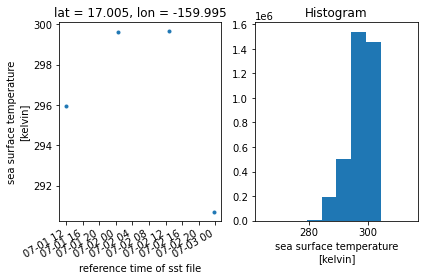

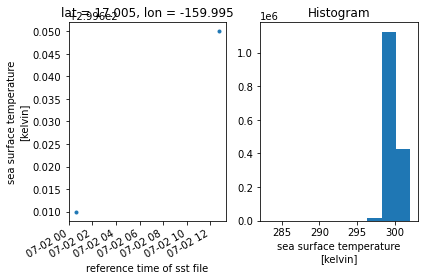

In [22]:
dataCube = download_dir + 'MODIS_SST.data-cube.nc'
xds = xr.open_dataset(dataCube)

# create objects for subplots
fig, axes = plt.subplots(ncols=2)

# plot a time series at a specific location
xds.sea_surface_temperature.isel(lat = 200, lon = 300).plot(ax=axes[0], marker = '.', linestyle = 'None')

# a histogram of all points in region of interest
xds.sea_surface_temperature.plot(ax=axes[1])

plt.tight_layout()
plt.draw()

# filter the dataset using quality information (quality_level value 4 and 5 are best data)
qc_dataset = xds.where((xds['sea_surface_temperature'] < 310) & (xds['quality_level'] >= 4))

# re-plot the time series at a specific location and the regional histogram
fig, axes = plt.subplots(ncols=2)
qc_dataset.sea_surface_temperature.isel(lat = 200, lon = 300).plot(ax=axes[0], marker = '.', linestyle = 'None')
qc_dataset.sea_surface_temperature.plot(ax=axes[1])

plt.tight_layout()
plt.draw()